In [17]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm


In [18]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
def preproccessing_alpha(train, test):
    """
    подготоваливаем данные. Первичная обработка.
    Вытаскиваем target и соединяес тестовой выборкой.
    
    @return all_data
    """
    # выделяем цели в отдельный столбец
    y = train['TARGET']
    # отделяем TARGET от тренировачных данных
    train = train.drop('TARGET', axis=1)
    # соеденим train и test
    # чтобы индексация было с 0 - n-1 , игнорирую начальную.
    all_data = pd.concat([train, test], ignore_index=True)
    return all_data, y 

In [50]:
def split_dataframe(dataframe, index):
    """
    делим данные на тренировачные и тестовые по индексу
    
    Parameters
    ----------
        dataframe: DataFrame
        index : int
    
    Return: 
        data_train, data_test
    """
    # Вновь разделите на train и test (не мешая)
    # t_data.
    data_train = dataframe[:index]
    data_test = dataframe[index:]
    return data_train, data_test


In [51]:
def cal_predict(x_train, y_train, x_test, blackbox):
    """
    Строим модель прогнозирования на основе черного ящика
    
    Return:
    _______
        predict, predict_proba 
    """
    model = blackbox # у квалификатора есть своё случайное значение.
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    predict_proba = model.predict_proba(x_test)
    return predict, predict_proba

In [52]:
def draw_hist(y_test, result_predicts, xlim=(-1, 15), ylim=(-0.01, 1.01), size=(5,10)):
    """
    Рисуем гистограмму. Особеность в параметре result_predicts. Это список кортежей.
    Каждый кортеж состоит из пары значений. 
    Первое - это список значений вероятностей predict_prob
    Второе - шаг изменения какого-то одного параметра обучаемой моделе.
    
    Parameters:
    __________
        y_test - тестовая выборка целевых значений.
        result_predicts - кортеж значений predict_prob со значением одного параметра обучаемой моделе
        xlim - plt.xlim
        ylim - plt.ylim
        size - plt.size 
    """
    
    steps = []
    scores = []
    for data in result_predicts:
        predict_prob, step = data
        score = roc_auc_score(y_test, predict_prob[:,1])
        steps.append(step)
        scores.append(score)
    
    plt.figure(figsize=size)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("steps")
    plt.ylabel("ROC_AUC")
    plt.bar(steps, scores)
    

In [53]:
def draw_roc_auc_multy(y_test, result_predicts):
    """
    Строим график нескольких roc_auc линей.
    
    Parameters:
    __________
        y_test - тестовая выборка целевых значений.
        result_predicts - кортеж значений predict_prob со значением одного параметра обучаемой моделе
        
    """
    
    plt.figure(figsize=(5, 10))
    plt.plot([0, 1], [0, 1])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.grid(True)
    plt.xlim((-0.01, 1.01))
    plt.ylim((-0.01, 1.01))
    for data in result_predicts:
        predict_prob, depth = data
        score = roc_auc_score(y_test, predict_prob[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:,1])
        plt.plot(fpr, tpr, label=f'ROC {score:.3f} {depth}')
    plt.legend( borderaxespad=0.)

In [54]:
def draw_roc_auc(y_test, predict_prob, tittle=""):
    """
    Считаем и рисуем  roc_auc метрику.
    
    Parameters:
    __________
        y_test - тестовая выборка целевых значений.
        result_predicts - кортеж значений predict_prob со значением одного параметра обучаемой моделе
        tittle - plt.tittle
    """
    # считаем площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций.
    score = roc_auc_score(y_test, predict_prob[:,1])

    fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:,1])
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.grid(True)
    plt.title(f'ROC curve {tittle} {score:.3f}')
    plt.xlim((-0.01, 1.01))
    plt.ylim((-0.01, 1.01))

## ГОТОВИМ ДАННЫЕ

In [55]:
train = pd.read_csv('./data/03_santander_train.csv', index_col='ID')

In [43]:
train.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [44]:
test = pd.read_csv('./data/03_santander_test.csv', index_col='ID')

In [45]:
test.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
ID,,,,,,,,,,,,,,,,,,,,,
2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


In [46]:
all_data, y = preproccessing_alpha(train, test)
# данные в полном порядке, все вещественные. Пропусков нет.
all_data.info(verbose=False, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151838 entries, 0 to 151837
Columns: 369 entries, var3 to var38
dtypes: float64(115), int64(254)
memory usage: 427.5 MB


In [47]:
data_train, data_test = split_dataframe(all_data, y.shape[0])

In [48]:
# Делаем hold-out sampling на train выборке
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data_train, y, test_size=0.33, random_state=42)

# sklearn.tree.DecisionTreeClassifier

In [56]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
predict_probs=[]
for depth in tqdm(range(1,15,2)):
    blackbox = DecisionTreeClassifier(max_depth=depth, random_state=42)
    predict, predict_prob = cal_predict(
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        blackbox=blackbox
    )
    predict_probs.append(( predict_prob, depth)) 

100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


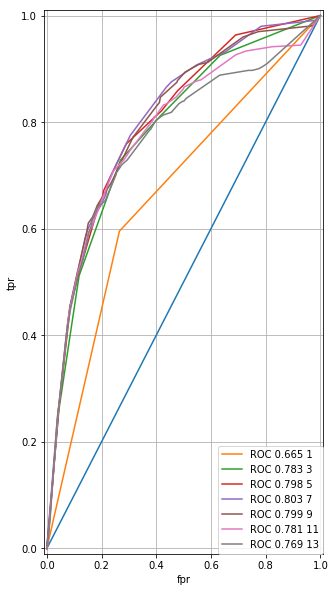

In [58]:
draw_roc_auc_multy(y_test, predict_probs)

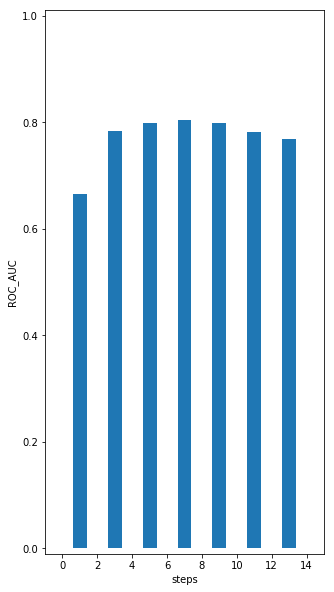

In [59]:
draw_hist(y_test, predict_probs)

# sklearn.neighbors.KNeighborsClassifier

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [72]:
predict_probs=[]
for neighbors in tqdm(range(1,50,3)):
    blackbox = KNeighborsClassifier(n_neighbors=neighbors, n_jobs=4)
    predict, predict_prob = cal_predict(
        x_train=X_train.iloc[:10000,:100],
        x_test=X_test.iloc[:10000,:100],
        y_train=y_train.iloc[:10000],
        blackbox=blackbox
    )
    predict_probs.append(( predict_prob, neighbors)) 

100%|██████████| 17/17 [08:12<00:00, 28.99s/it]


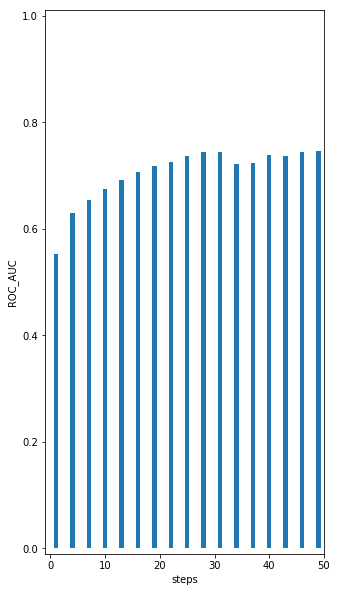

In [75]:
draw_hist(y_test.iloc[:10000], predict_probs , xlim =(-1, 50))

# sklearn.linear_model.LogisticRegression

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
predict_probs=[]
for value in tqdm(range(1,50,2)):
    blackbox = LogisticRegression(penalty='l2', C=value)
    predict, predict_prob = cal_predict(
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        blackbox=blackbox
    )
    predict_probs.append(( predict_prob, value)) 


  0%|          | 0/25 [00:00<?, ?it/s]
Exception in thread Thread-599:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 25/25 [02:13<00:00,  5.34s/it]


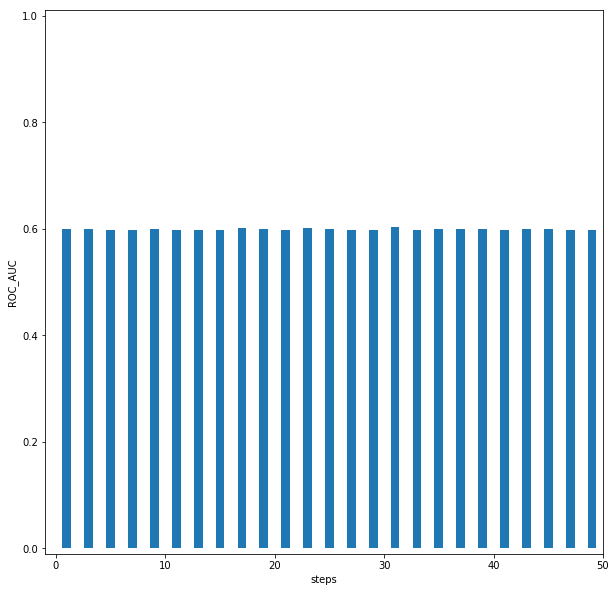

In [82]:
draw_hist(y_test, predict_probs, xlim=(-1,50), size=(10,10))

In [83]:
predict_probs=[]
for value in tqdm(range(1,20,2)):
    blackbox = LogisticRegression(penalty='l1', C=value)
    predict, predict_prob = cal_predict(
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        blackbox=blackbox
    )
    predict_probs.append(( predict_prob, value)) 

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
100%|██████████| 10/10 [2:05:02<00:00, 750.22s/it] 


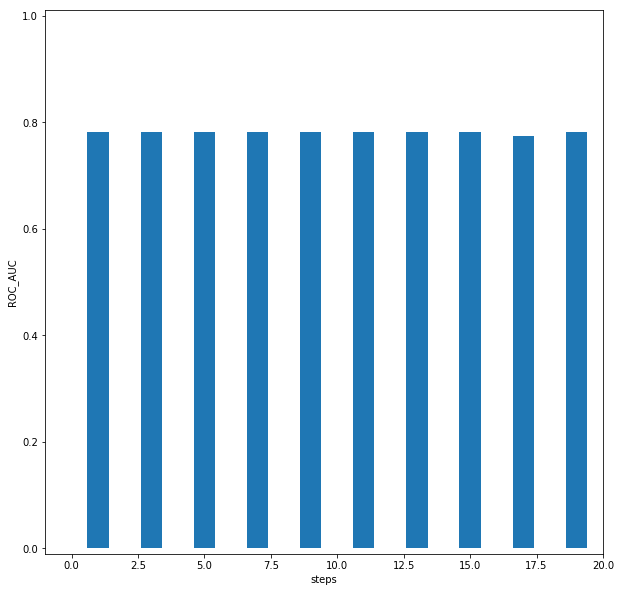

In [87]:
draw_hist(y_test, predict_probs, xlim=(-1,20), size=(10,10))

https://www.kaggle.com/cast42/exploring-features